In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
# imports
from pathlib import Path
import sys  

# Get my_package directory path from Notebook
parent_dir = str(Path().resolve().parents[0])

# Add to sys.path
sys.path.insert(0, parent_dir)

In [3]:
from utils.experiment_utils import get_all_experiments_info, load_best_model
import torch
import os
import hydra
from omegaconf import DictConfig, OmegaConf

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from notebooks.mnist_classifier.mnist_tiny_cnn import TinyCNN

from mixer.mixer import SetMixer
from datasets.mnist import MNISTDataset

from torch.utils.data import DataLoader
from itertools import product

from tqdm.notebook import tqdm

from datasets.distribution_datasets import GaussianMixtureModelDistributionDataset
from utils.gmm_utils import fit_gmm_batch

from ot.gmm import gmm_ot_loss

import warnings
warnings.filterwarnings("ignore")

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.


In [5]:
device = 'cuda'
configs = get_all_experiments_info('/orcd/data/omarabu/001/gokul/DistributionEmbeddings/outputs/', False)
cfg = [
    c for c in configs if 'gmm_sys' in c['name'] and c['config']['dataset']['data_shape'] == [5] and c['config']['training']['max_time'] == 300
]

print(len(cfg))

# load model and move to device
def load_model(cfg, path, device):
    enc = hydra.utils.instantiate(cfg['encoder'])
    gen = hydra.utils.instantiate(cfg['generator'])
    state = load_best_model(path)
    enc.load_state_dict(state['encoder_state_dict'])
    gen.model.load_state_dict(state['generator_state_dict'])
    enc.eval()
    gen.eval()
    enc.to(device)
    gen.to(device)
    return enc, gen

30


In [7]:
d = {
    "Encoder" : [],
    "Generator" : [],
    "N dims" : [],
    "OT reconstruction error" : []
}

N_sets = 200
set_size = 10**4
dataset = GaussianMixtureModelDistributionDataset(
    n_sets=N_sets,
    set_size=set_size,
    prior_mu=(0,5),
    data_shape=[5]
)


for c in tqdm(cfg):
    encoder_name = c['encoder']
    generator_name = c['generator']
    if generator_name == 'DirectGenerator':
        generator_name += '-' + c['config']['generator']['loss_type']
    data_shape = c['config']['dataset']['data_shape']
    num_epochs = c['config']['training']['num_epochs']

    try:
        enc, gen = load_model(c['config'], c['dir'], device=device)
    except:
        print('broken: ', encoder_name, generator_name)
        continue

    if 'Tx' not in encoder_name and 'Wormhole' not in encoder_name:
        set_size = 10**4
    else:
        set_size=10**3

    data = dataset.data[:, :set_size, :]
    
    ot_errors = []
    for idx in range(len(dataset)//8):

        with torch.no_grad():
            x = torch.tensor(data[idx*8:(idx+1)*8], dtype=torch.float).cuda()
            z = enc(x)
            x_hat = gen.sample(z, num_samples=10**4)

        mus = dataset.mu[idx*8:(idx+1)*8]
        covs = dataset.cov[idx*8:(idx+1)*8]
        weights = dataset.weights[idx*8:(idx+1)*8]


        r_means, r_covs, r_weights = fit_gmm_batch(
            x_hat.detach().cpu().numpy(), 
            mus,
            covs,
            weights,
            # use_kmeans_init=True
        )

        x = x.cpu()
        x_hat = x_hat.detach().cpu()
        
        ot_dists = [
            gmm_ot_loss(r_m, m, r_c, c, r_w, w) 
            for r_m, m, r_c, c, r_w, w in zip(r_means, mus, r_covs, covs, r_weights, weights)
        ]
        ot_errors += ot_dists

    d['Encoder'].append(encoder_name)
    d['Generator'].append(generator_name)
    d['N dims'].append(data_shape[0])
    d['OT reconstruction error'].append(np.mean(ot_errors))
    print(f"Encoder: {encoder_name}, Generator: {generator_name}, OT error: {np.mean(ot_errors)}, data shape: {data_shape[0]}")

  0%|          | 0/30 [00:00<?, ?it/s]

Encoder: DistributionEncoderGNN, Generator: WormholeGenerator, OT error: 4.798457580299313, data shape: 5
Encoder: DistributionEncoderResNet, Generator: CVAE, OT error: 5.875630004613274, data shape: 5
Encoder: MeanEncoder, Generator: CVAE, OT error: 5.919563709624381, data shape: 5
Encoder: DistributionEncoderMedianGNN, Generator: DirectGenerator-swd, OT error: 3.3670512572468687, data shape: 5
Encoder: DistributionEncoderMedianGNN, Generator: DDPM, OT error: 2.0823704167867105, data shape: 5
Encoder: KMEEncoder, Generator: DDPM, OT error: 2.2937292894561967, data shape: 5
Encoder: DistributionEncoderResNet, Generator: DDPM, OT error: 2.4991701651044766, data shape: 5
Encoder: DistributionEncoderMedianGNN, Generator: CVAE, OT error: 7.385371536976465, data shape: 5
Encoder: DistributionEncoderGNN, Generator: CVAE, OT error: 8.43687314266347, data shape: 5
Encoder: WormholeEncoder, Generator: DirectGenerator-sinkhorn, OT error: 3.619235218291255, data shape: 5
Encoder: MeanEncoder, Gen

In [8]:
pd.DataFrame(d).sort_values(by='OT reconstruction error')

,Encoder,Generator,N dims,OT reconstruction error
22,KMEEncoder,WormholeGenerator,5,1.770594
4,DistributionEncoderMedianGNN,DDPM,5,2.082370
5,KMEEncoder,DDPM,5,2.293729
25,DistributionEncoderGNN,DDPM,5,2.326192
18,WormholeEncoder,WormholeGenerator,5,2.484893
6,DistributionEncoderResNet,DDPM,5,2.499170
21,DistributionEncoderResNet,WormholeGenerator,5,2.521793
20,DistributionEncoderMedianGNN,DirectGenerator-sinkhorn,5,2.574494
17,DistributionEncoderResNet,DirectGenerator-sinkhorn,5,2.693870
28,WormholeEncoder,DDPM,5,2.878665


<Axes: xlabel='Generator', ylabel='Encoder'>

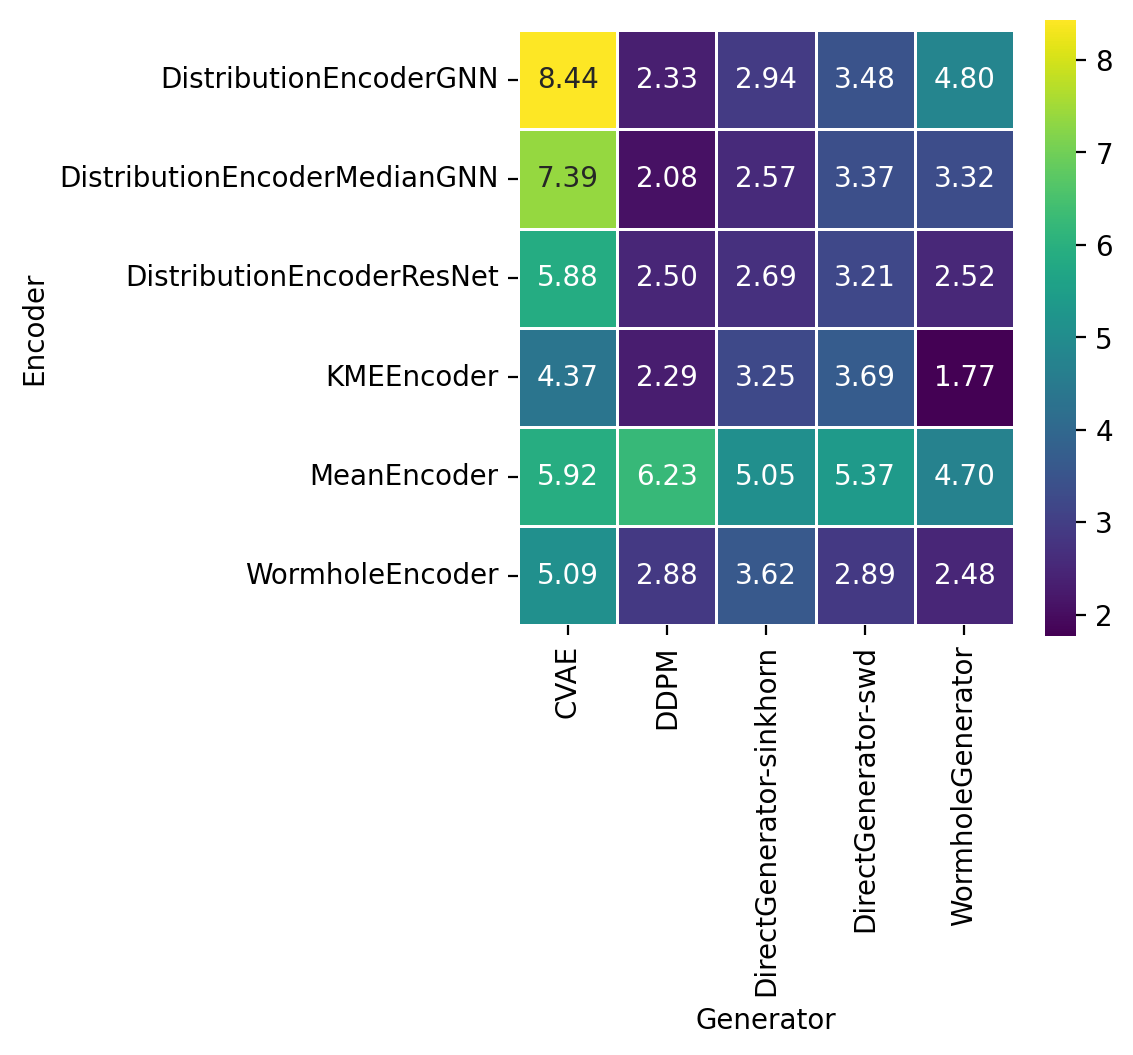

In [9]:
df = pd.DataFrame(d)

plt.figure(figsize=(4,4), dpi=200)
sns.heatmap(df.pivot_table(index='Encoder', columns='Generator', values='OT reconstruction error'), 
            annot=True, fmt=".2f", cmap="viridis", square=True, lw=0.5)